# Tasks

* Implement vanilla autoencoder
* Train it on MNIST dataset MNIST
* Display digits recovered dy AE
* Display distribution of embeddings in latent space

# Dataset

http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples.

The images were centered in a 28x28 image by computing the center of mass of the pixels.



In [59]:
import random
import os
import numpy as np
import torch


def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [60]:
import torch, torchvision
from torchvision.datasets import MNIST
from torchvision import transforms, utils

transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

train_dataset = MNIST('/datasets/mnist',
                      train=True,
                      download=True,
                      transform=transf
                      )

test_dataset = MNIST('/datasets/mnist',
                     train=False,
                     download=True,
                     transform=transf
                     )

Display some samples along with corresponding labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


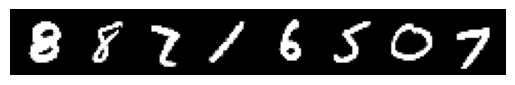

[8 8 7 1 6 5 0 7]


In [61]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


# Helper method
def show(grid):
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.show()


vis_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)  # img1,  label

# display the data
grid = torchvision.utils.make_grid(example_batch[0])
show(grid)
print(example_batch[1].numpy())

In [62]:
example_batch[0].shape

torch.Size([8, 1, 28, 28])

# Model

Implement vanilla autoencoder model.

In [63]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size

        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)

        self.act = nn.ReLU(True)

        self.lin = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(3 * 3 * 64, self.latent_size)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        x = self.conv3(x)
        x = self.act(x)

        embedding = self.lin(x)

        return embedding


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size

        self.t_conv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=0)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)

        self.act = nn.ReLU(True)

        self.lin = nn.Sequential(
            nn.Linear(self.latent_size, 3 * 3 * 64),
            nn.Unflatten(1, (64, 3, 3)),
        )

    def forward(self, x):
        x = self.lin(x)

        x = self.t_conv1(x)
        x = self.bn1(x)
        x = self.act(x)

        x = self.t_conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        x = self.t_conv3(x)

        recovered = torch.sigmoid(x)

        return recovered

## Smoke test

In [64]:
encoder = Encoder(2)
dummy = torch.randn((1, 1, 28, 28))
print("Encoder In", dummy.shape)
embedding = encoder(dummy)
print("Encoder Out", embedding.shape)

decoder = Decoder(2)
recovered = decoder(embedding)
print("Decoder Out", recovered.shape)

assert (dummy.shape == recovered.shape), "Decoder out shape must be equal to input shape"

Encoder In torch.Size([1, 1, 28, 28])
Encoder Out torch.Size([1, 2])
Decoder Out torch.Size([1, 1, 28, 28])


### AE

Implement AutoEncoder class. 
Use Decoder and Encoder classes implemented early.

In [65]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.latent_size = latent_size
        self.enc = Encoder(self.latent_size)
        self.dec = Decoder(self.latent_size)

    def forward(self, x):
        embedding = self.enc(x)
        recovered_x = self.dec(embedding)

        return recovered_x, embedding

# Train

Define dataloaders

In [66]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=256)

Define main training routine and train your model

In [67]:
import pytorch_lightning as pl

seed_everything(123456)


class ImportedModelTrainer(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.learning_rate = lr

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        return {"optimizer": self.optimizer}

    def training_step(self, train_batch, batch_idx):
        images, _ = train_batch

        preds = self.forward(images)[0]

        loss = self.loss(preds, images)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, _ = val_batch
        preds = self.forward(images)[0]

        loss = self.loss(preds, images)
        self.log("val_loss", loss, prog_bar=True)

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

model = AutoEncoder(64).to(device)
module = ImportedModelTrainer(model=model, lr=8e-4)

Training on cuda


In [69]:
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb.finish()
wandb.init(project="cv-AE", entity="dmitysh")
wandb_logger = WandbLogger(log_model='all')
trainer = pl.Trainer(accelerator="gpu", devices=-1, max_epochs=10, logger=wandb_logger, log_every_n_steps=100)

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▂▂▁▂▂▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,9
train_loss,0.4627
trainer/global_step,4689
val_loss,0.47362


C:\pyVenvs\mlvenv\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [71]:
trainer.fit(module, train_dataloader, test_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | AutoEncoder | 121 K 
1 | loss  | MSELoss     | 0     
--------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.484     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\pyVenvs\mlvenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\pyVenvs\mlvenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\pyVenvs\mlvenv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory .\lightning_logs\3tpne3pp\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | AutoEncoder | 121 K 
1 | loss  | MSELoss     | 0     
--------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.484     Total estimate

Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Let's test the model

Compare original and recovered digits.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


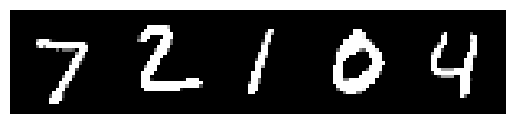

[7 2 1 0 4]


In [72]:
dataiter = iter(test_dataloader)
example_batch = next(dataiter)  # img1,  label

grid = torchvision.utils.make_grid(example_batch[0][:5])
show(grid)
print(example_batch[1].numpy()[:5])

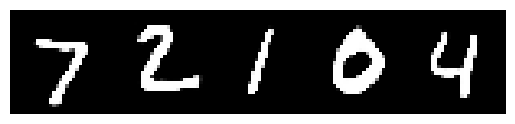

In [73]:
res = model(example_batch[0][:5])
grid = torchvision.utils.make_grid(res[0])
show(grid)

Show embeddings positions in latent space

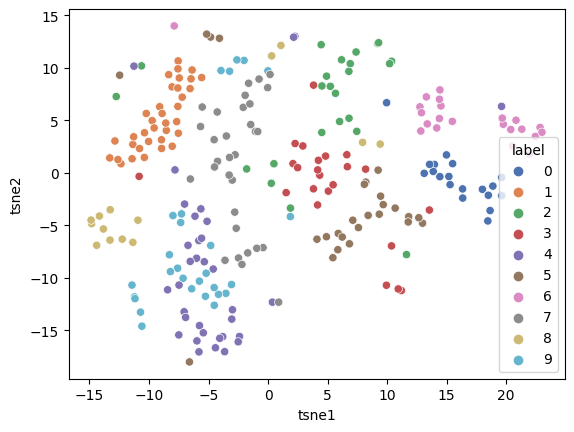

In [74]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

res = model(example_batch[0])
tsne = TSNE()
tsne_results = tsne.fit_transform(res[1].detach())

tsne_results = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_results['label'] = example_batch[1].tolist()

sns.scatterplot(data=tsne_results, x="tsne1", y="tsne2", hue="label", palette="deep")
plt.show()

# Conclusion

- Реализовал Encoder, Decoder, AE
- Понял, что ReLU в качестве последней активации декодера не дает обучить модель
- Попробовал несколько архитектур (менял размеры сверток и добавлял батчнормы)
- Попробовал разные latent size
- Попробовал BCE И MSE лоссы (скрыл BCE в графиках ниже, так как у лоссов сильно разный масштаб с MSE)

# Ideas for extra work

* Find the best latent space size
* Implement noise filtration with AE
* Test vector arithmetic in laent space
* Implemet VAE 
** Use Autoencoder class as base class
** Implement VAE Loss class
** Plot embeddings manifold in VAE latent space
** Compare decoding results VAE latent space with vanilla Autoencoder results
* Replace reconstruction loss from MSE to BCE
* Implement Conditional Autoencoder or CVAE

## Wandb
https://wandb.ai/dmitysh/cv-AE?workspace=user-dmitysh

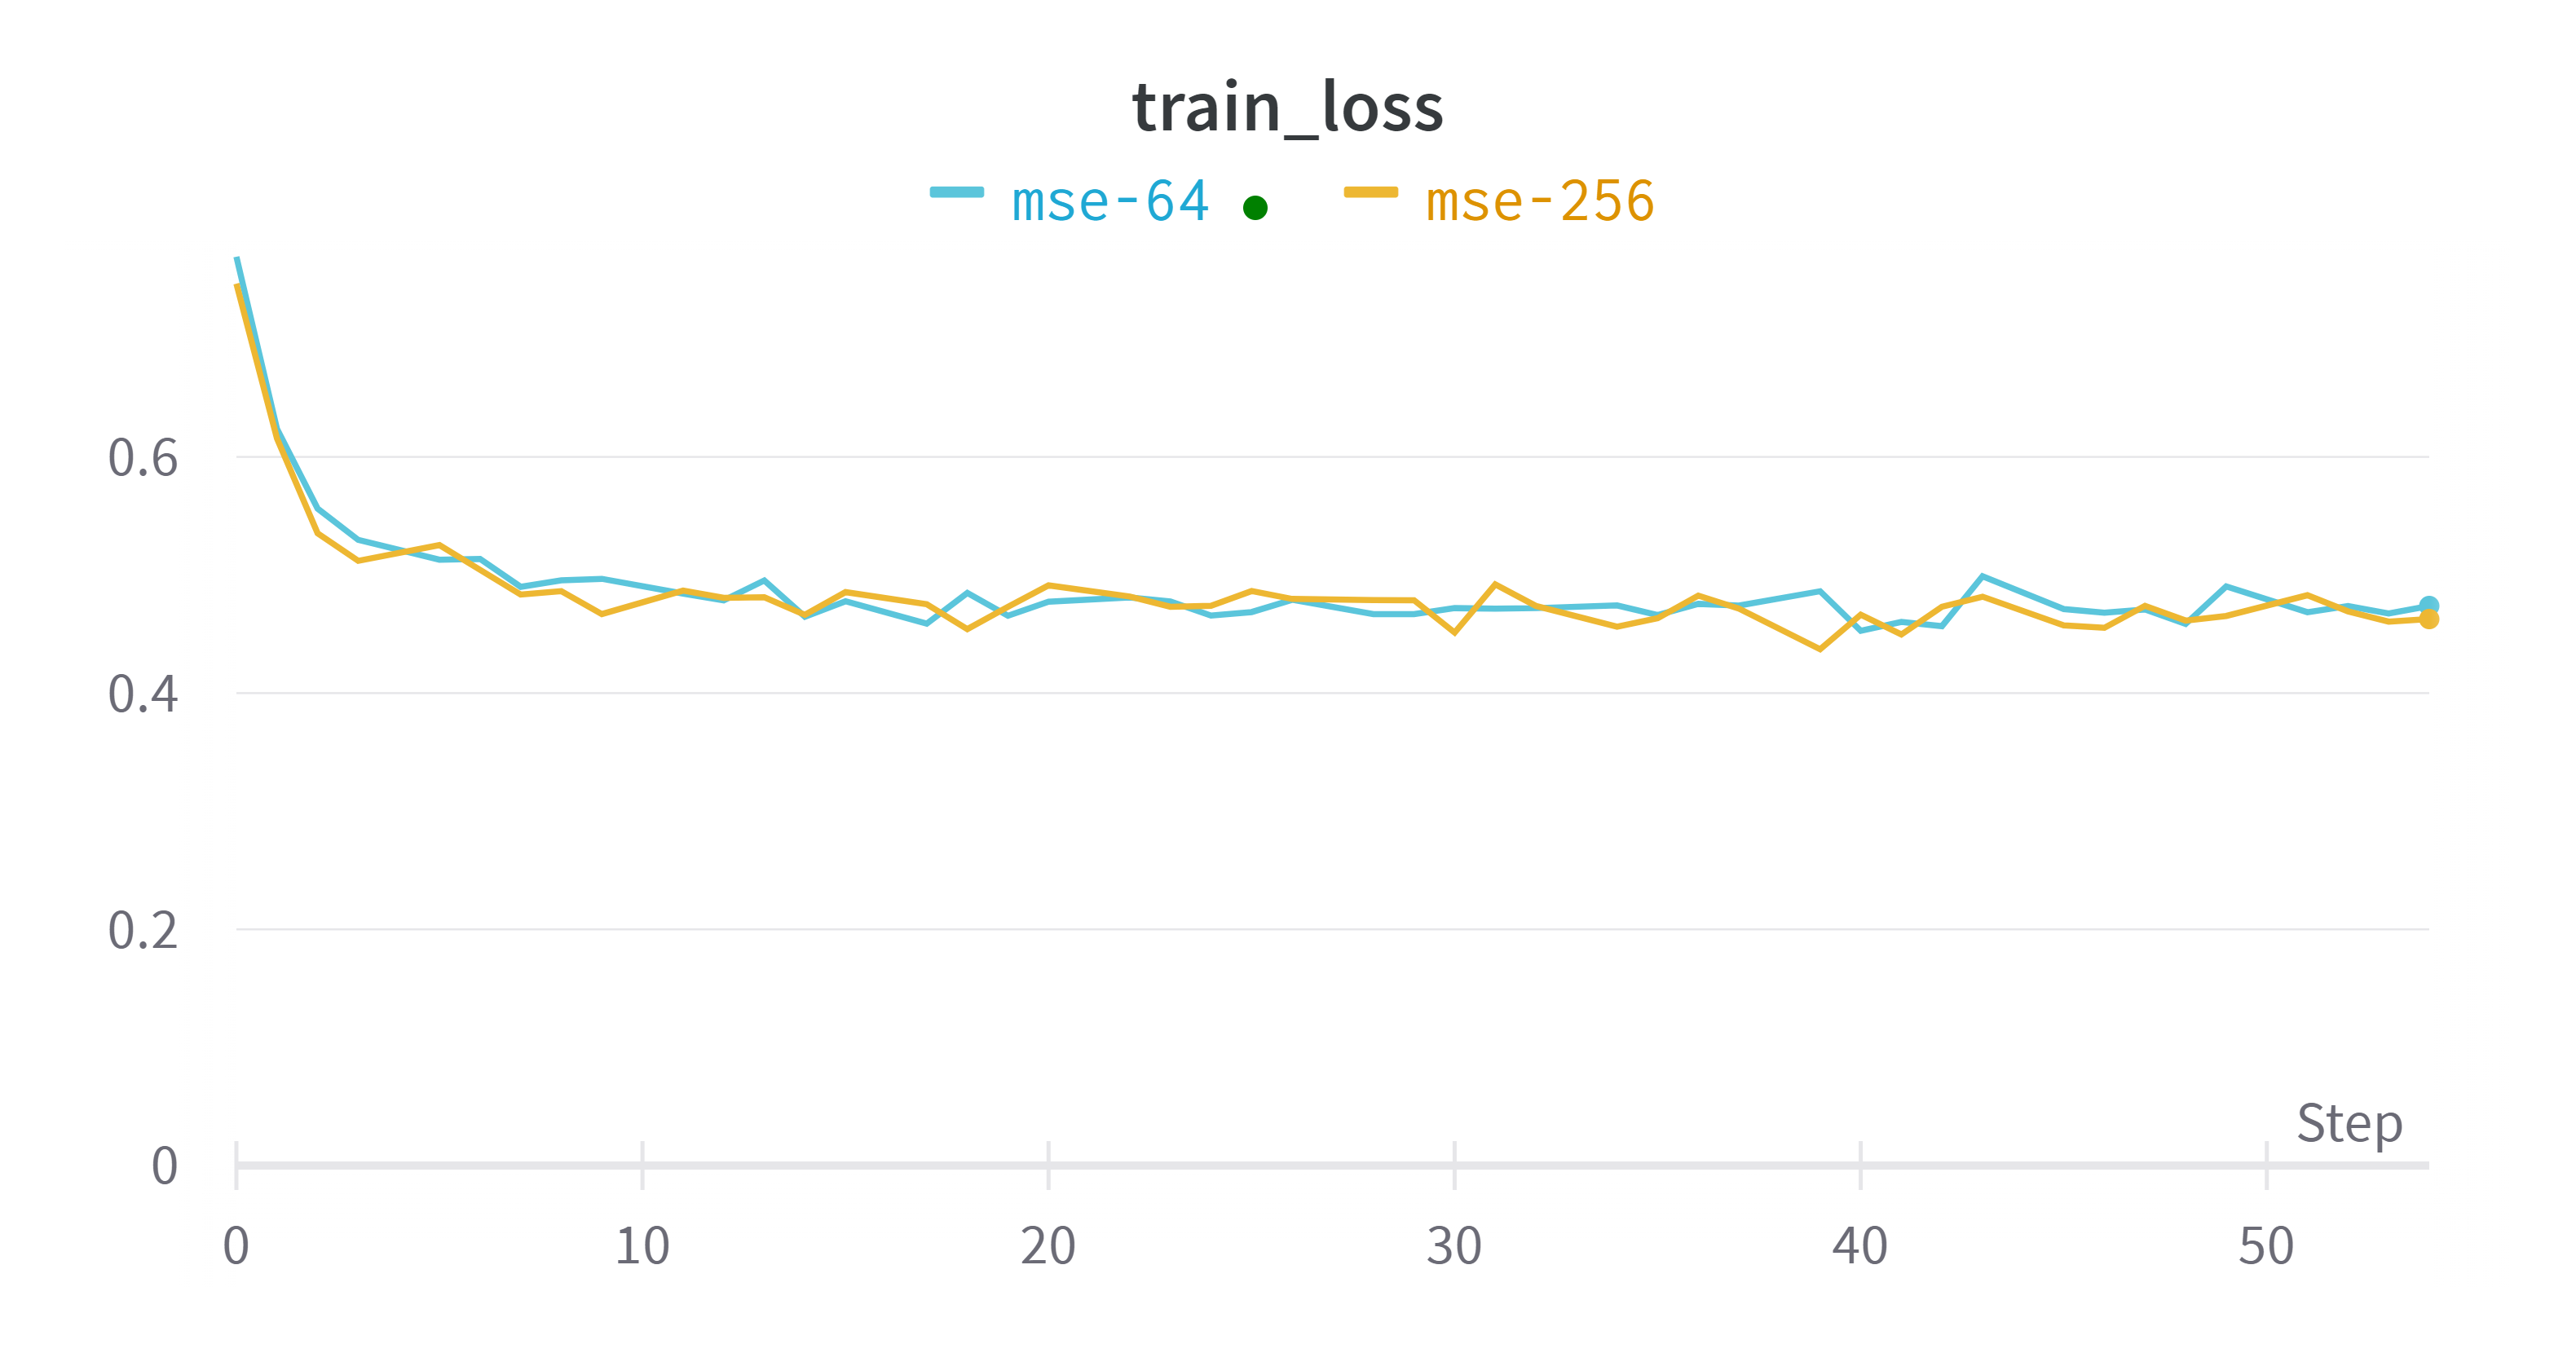

In [75]:
from IPython.display import Image
Image('img/train_loss.png')

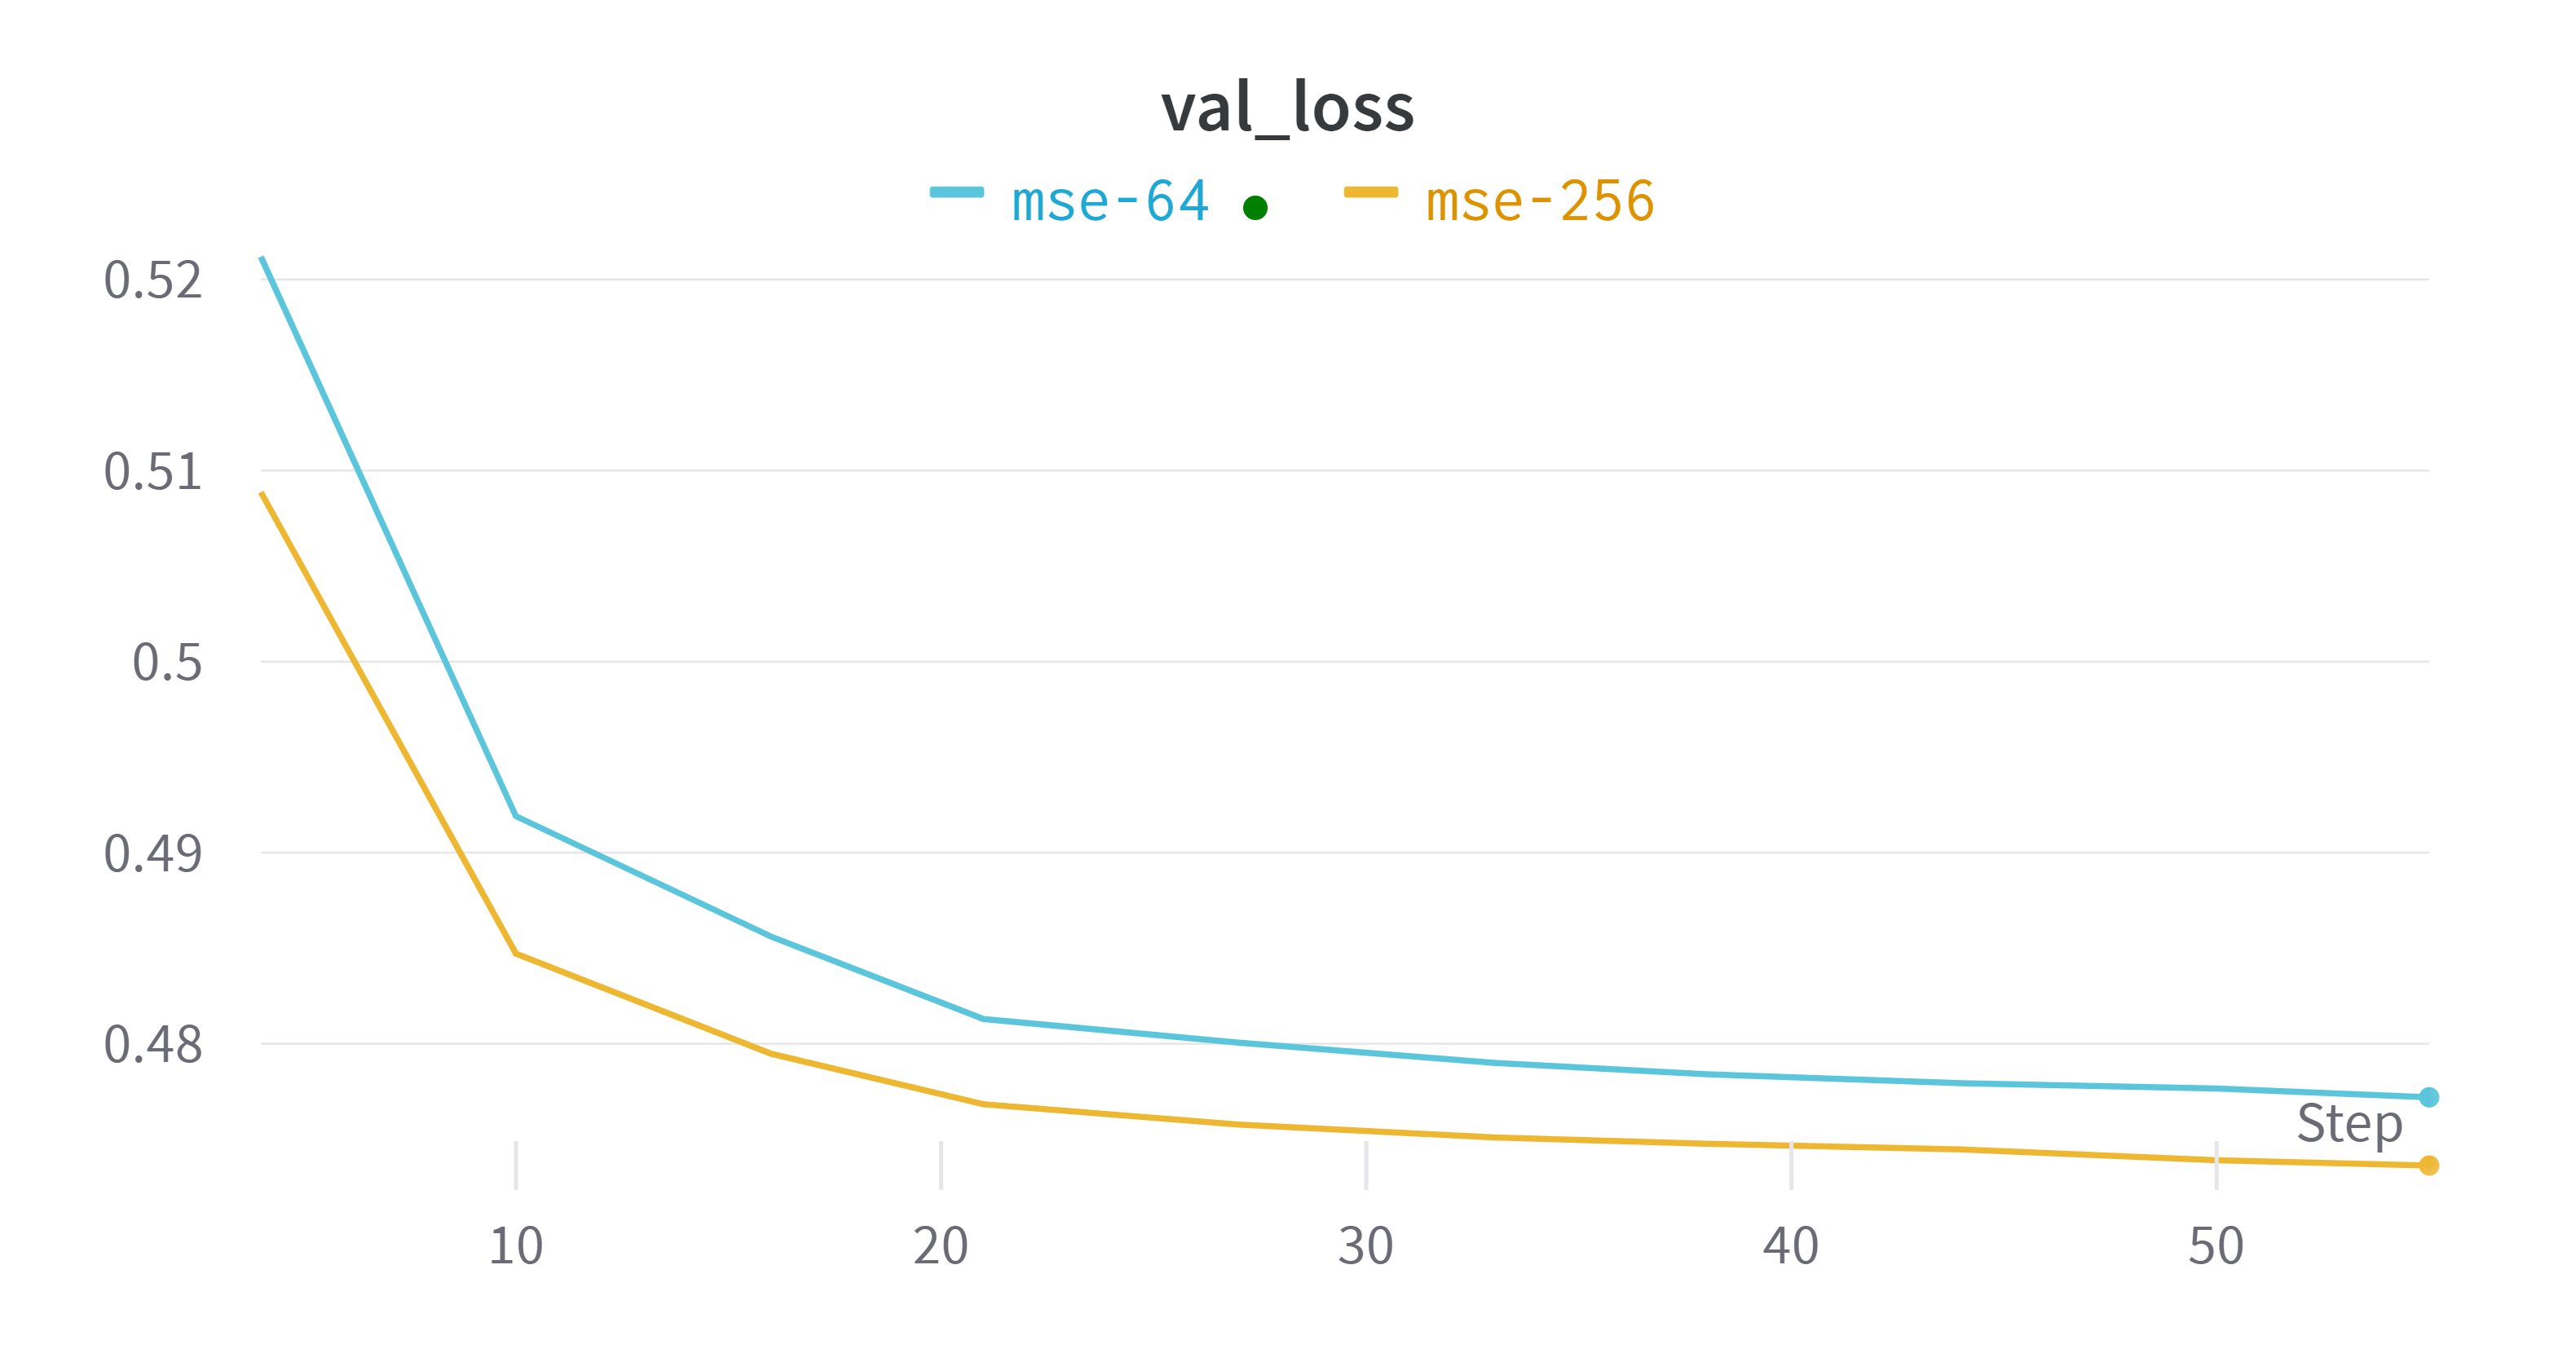

In [76]:
Image('img/val_loss.png')
